In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from scipy.stats import chi2_contingency
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.multitest import multipletests
from scipy.special import erf
from lifelines import CoxTimeVaryingFitter
import cmdstanpy
from cmdstanpy import CmdStanModel
import arviz as az

from multipathogen_sero import (
    simulate_infections_seroreversion,
    simulation_to_regression_df,
    simulation_to_survey_wide,
    get_constant_foi,
    get_constant_foi_survivor
)

from multipathogen_sero.config import PROJ_ROOT, STAN_DIR, MODEL_FITS_DIR

2025-08-16 00:34:01.150 | INFO     | multipathogen_sero.config:<module>:12 - PROJ_ROOT path is: /home/ayan/sero/multipathogen-sero


# Simulation

In [12]:
n_people = 10000 #number of individuals n
np.random.seed(42)  # For reproducibility
t_max=100
birth_times = np.random.uniform(0, t_max, size=n_people)  # Random birth times for individuals
n_pathogens=2 #number of pathogens K

pathogen_names = [f'Pathogen {i}' for i in range(1,n_pathogens+1)]  # Names for pathogens
#foi_list = [get_exponential_foi(0, 1) for k, pathogen_name in enumerate(pathogen_names)]

baseline_hazards = [0.1*k for k in range(1,n_pathogens+1)]  # Example baseline hazards
foi_list = [
    get_constant_foi(a=baseline_hazards[k]) for k in range(n_pathogens)
]
survivor_list = [
    get_constant_foi_survivor(a=baseline_hazards[k]) for k in range(n_pathogens)
]
# spike and slab on each coefficient of the interaction matrix
np.random.seed(42)  # For reproducibility
interaction_indicator = np.random.binomial(1, 0.1, size=(n_pathogens, n_pathogens))
interaction_indicator[np.arange(n_pathogens), np.arange(n_pathogens)] = 0
beta_mat = np.random.normal(0, 1, size=(n_pathogens, n_pathogens)) * interaction_indicator
interaction_mat = np.exp(beta_mat)

In [13]:
start = time.time()
simulate_infections_seroreversion_df = simulate_infections_seroreversion(
    n_people,
    n_pathogens,
    foi_list,
    interaction_mat=interaction_mat,
    seroreversion_rates=None,
    birth_times=birth_times,
    end_times=t_max,
    max_fois=None,
    random_seed=42
)
print(f"simulate_infections_seroreversion took {time.time() - start:.3f} seconds")


simulate_infections_seroreversion took 0.900 seconds


In [ ]:
survey_every = 10.0
survey_times = {
    i + 1: survey_every * np.arange(np.floor(birth_times[i]/survey_every)+1, np.floor(t_max/survey_every)+1)
    # i+1: np.insert(
    #     survey_every * np.arange(np.floor(birth_times[i]/survey_every)+1, np.floor(t_max/survey_every)+1),
    #     0, birth_times[i]
    # )
    for i in range(n_people)
}
survey_wide = simulation_to_survey_wide(
    simulate_infections_seroreversion_df,
    survey_times=survey_times
)

# Inference

In [15]:
"""
data {
    int<lower=1> N;                         // Number of individuals
    array[N] int<lower=1> num_tests;                 // Number of serological tests for each individual
    int<lower=1> num_tests_total; // Total number of serological tests across all individuals
    int<lower=1> K;                         // Number of pathogens
    array[num_tests_total] real test_times; // Time of each serological test
    array[num_tests_total,K] int<lower=0, upper=1> serostatus; // Seropositivity for each test and pathogen

    real <lower=0> beta_scale; // scale for Laplace prior on log hazard ratios
}
"""
# TODO: write tests
stan_data = {
    "N": n_people,
    "K": n_pathogens,
    "num_tests": survey_wide.groupby('individual').size().values,
    "num_tests_total": len(survey_wide),
    "test_times": survey_wide['time'].values,
    "serostatus": survey_wide[[col for col in survey_wide.columns if col.startswith('serostatus_')]].values.astype(int),  # Convert to int for Stan
    "interval": survey_every,
    "log_baseline_hazard_mean": -1,
    "log_baseline_hazard_scale": 0.5,
    "beta_scale": 1.0,  # scale for Laplace prior on log hazard ratios
}

In [16]:
model = CmdStanModel(
    stan_file=os.path.join(STAN_DIR, "multiplex_serology_seroreversion.stan")
)
fit = model.sample(
    data=stan_data,
    chains=4,
    iter_sampling=500,
    iter_warmup=500,
    parallel_chains=4,
    seed=42,
    show_console=False
)

00:39:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

00:49:01 - cmdstanpy - INFO - CmdStan done processing.


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.

Any R-hat > 1.01? False
Any ESS < 400? False


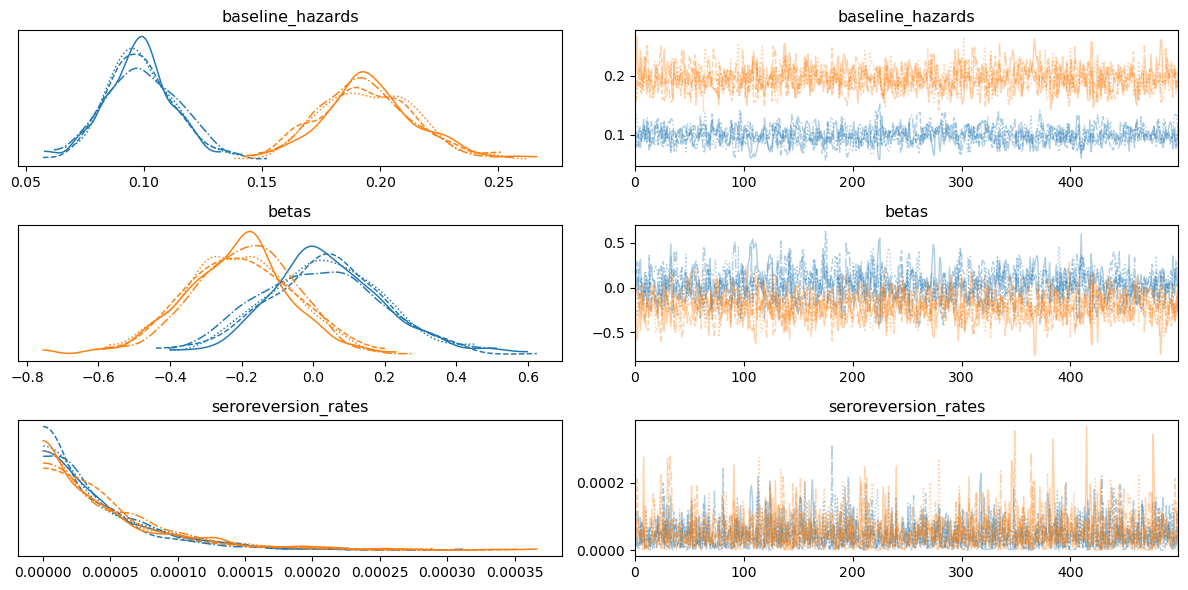

In [9]:
# Print summary
print(fit.diagnose())

# Check R-hat and ESS
df_summary = fit.summary()
print("Any R-hat > 1.01?", (df_summary["R_hat"] > 1.01).any())
print("Any ESS < 400?", (df_summary["ESS_bulk"] < 400).any())

# Optional: convert to ArviZ for easier plotting
idata = az.from_cmdstanpy(posterior=fit)

# Plot trace plots
az.plot_trace(idata, var_names=["baseline_hazards", "betas", "seroreversion_rates"])
plt.tight_layout()
plt.show()

In [10]:
import re
import numpy as np

def extract_array_parameters_from_last_draw(fit, chain):
    """
    Extracts all array parameters from the last draw of a CmdStanPy fit,
    reconstructing their original shapes.
    Returns a dictionary: {param_base_name: np.ndarray}
    """
    # Get parameter names (excluding sampler diagnostics)
    param_names = [name for name in fit.column_names if not name.endswith('__')]
    last_draw = fit.draws()[chain, 0, :]  # last draw, first chain
    param_dict = dict(zip(fit.column_names, last_draw))

    arrays = {}
    # Group parameter names by base name and indices
    pattern = re.compile(r"^([^\[]+)\[(.+)\]$")
    grouped = {}
    for name in param_names:
        m = pattern.match(name)
        if m:
            base = m.group(1)
            idx = tuple(int(i) for i in m.group(2).split(','))
            grouped.setdefault(base, []).append((idx, param_dict[name]))
        else:
            arrays[name] = param_dict[name]  # scalar

    # Reconstruct arrays
    for base, items in grouped.items():
        # Find shape
        indices = np.array([idx for idx, _ in items])
        shape = indices.max(axis=0)
        arr = np.empty(shape, dtype=float)
        for idx, value in items:
            arr[tuple(i-1 for i in idx)] = value  # Stan is 1-based
        arrays[base] = arr

    return arrays

# Usage:
arrays = extract_array_parameters_from_last_draw(fit, 0)
for k, v in arrays.items():
    print(f"{k}: {v}\n")

baseline_hazards: [0.090309 0.188447]

seroreversion_rates: [1.01983e-05 7.60368e-05]

betas: [-0.0165249 -0.138108 ]

beta_matrix: [[ 0.        -0.0165249]
 [-0.138108   0.       ]]

q_matrix: [[-2.78756e-01  9.03090e-02  1.88447e-01  0.00000e+00]
 [ 1.01983e-05 -1.64148e-01  0.00000e+00  1.64138e-01]
 [ 7.60368e-05  0.00000e+00 -8.89050e-02  8.88289e-02]
 [ 0.00000e+00  7.60368e-05  1.01983e-05 -8.62351e-05]]

transition_matrix: [[6.16682e-02 1.04249e-01 3.46990e-01 4.87093e-01]
 [1.17717e-05 1.93925e-01 5.56680e-05 8.06007e-01]
 [1.40008e-04 2.16500e-04 4.11243e-01 5.88400e-01]
 [2.37612e-08 3.73382e-04 6.75540e-05 9.99559e-01]]

log_lik: [-7.21506e-01  0.00000e+00 -5.30789e-01 -7.20624e-01 -3.52846e-03
 -5.33435e-01 -7.22830e-01 -1.05846e+00 -2.16544e-01 -5.30789e-01
 -3.96951e-03  0.00000e+00 -5.30348e-01 -3.08740e-03 -2.18750e-01
 -1.42156e+00 -1.42068e+00 -5.31671e-01 -2.17427e-01 -1.59101e+00
 -1.32317e-03 -3.52846e-03 -1.59101e+00 -5.32553e-01 -2.17427e-01
 -5.30789e-01 -2.479

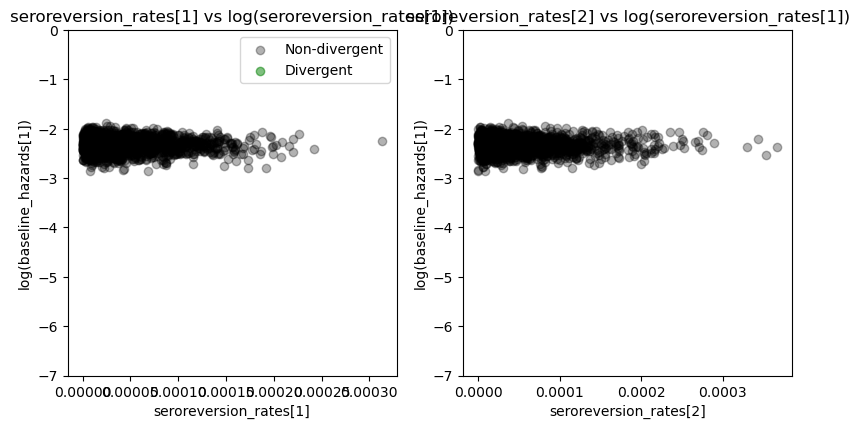

In [11]:
# Extract posterior samples
betas_samples = fit.stan_variable(f'seroreversion_rates')
hazard_samples = fit.stan_variable('baseline_hazards')[:, 0]  # first value

# Get the sampler diagnostics as a DataFrame
diagnostics = fit.draws_pd(vars=['divergent__'])

# Flatten to a 1D boolean mask (True if divergent)
div_mask = diagnostics['divergent__'].values.astype(bool)
nondiv_mask = ~div_mask

plt.figure(figsize=(12, 8))
for k in range(2):
    plt.subplot(2, 3, k+1)
    plt.scatter(
        betas_samples[nondiv_mask, k],
        np.log(hazard_samples[nondiv_mask]),
        color='black', alpha=0.3, label='Non-divergent'
    )
    plt.scatter(
        betas_samples[div_mask, k],
        np.log(hazard_samples[div_mask]),
        color='green', alpha=0.5, label='Divergent'
    )
    plt.xlabel(f'seroreversion_rates[{k+1}]')
    plt.ylabel('log(baseline_hazards[1])')
    plt.title(f'seroreversion_rates[{k+1}] vs log(seroreversion_rates[1])')
    plt.ylim(-7, 0)
    if k == 0:
        plt.legend()

plt.tight_layout()
plt.show()